# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# Drawing
import matplotlib.pyplot as plt

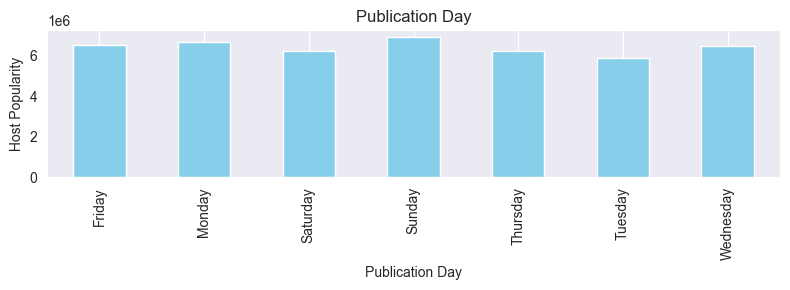

In [2]:
df = pd.read_csv('train.csv')

grouped_1 = df.groupby('Publication_Day')['Host_Popularity_percentage'].sum()

# bar
plt.figure(figsize=(8, 3))
grouped_1.plot(kind='bar', color='skyblue')
plt.xlabel('Publication Day')
plt.ylabel(' Host Popularity ')
plt.title('Publication Day')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [3]:
df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


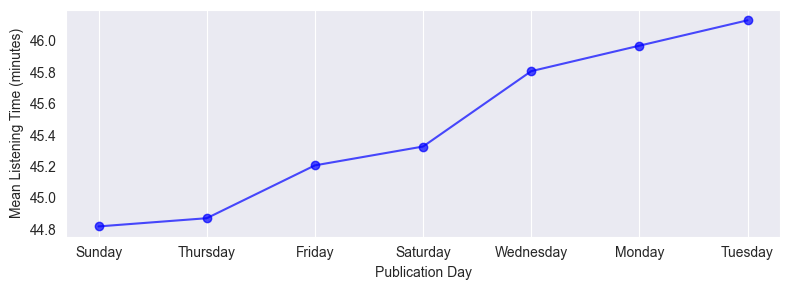

In [4]:
import matplotlib.pyplot as plt

# Group by 'Publication_Day' and calculate the mean of 'Listening_Time_minutes'
grouped_2 = df.groupby('Publication_Day')['Listening_Time_minutes'].mean()

# Sort by the mean of 'Listening_Time_minutes' in ascending order
grouped_2_sorted = grouped_2.sort_values()

plt.figure(figsize=(8, 3))

# Use the grouped data for plotting
x = grouped_2_sorted.index
y = grouped_2_sorted.values
plt.plot(x, y, alpha=0.7, color='blue', marker='o', markersize=6, linestyle='-', markerfacecolor='blue')

plt.xlabel('Publication Day')
plt.ylabel('Mean Listening Time (minutes)')
plt.grid(axis='y')

plt.tight_layout()
plt.show()


# Some Utility Functions

You do not need to modify this part.

In [5]:
def same_seed(seed):
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set))
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

# Dataset

In [6]:
class BackpackDataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Neural Network Model
Try out different model architectures by modifying the class below.

In [7]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        self.layers = nn.Sequential(
nn.Linear(input_dim, 128),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.LeakyReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x


# Feature Selection
Choose features you deem useful by modifying the function below.

In [8]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    # 填充 NaN
    imputer = SimpleImputer(strategy='most_frequent')  # 使用均值填充
    raw_x_train = imputer.fit_transform(raw_x_train)
    raw_x_valid = imputer.transform(raw_x_valid)
    raw_x_test = imputer.transform(raw_x_test)

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        selector = SelectKBest(score_func=f_regression, k=8)  # 选择 k 个最佳特征
        selector.fit(raw_x_train, y_train)  # 训练特征选择器
        feat_idx = selector.get_support(indices=True)  # 获取选中的特征索引

    return raw_x_train[:, feat_idx], raw_x_valid[:, feat_idx], raw_x_test[:, feat_idx], y_train, y_valid


# Training Loop

In [9]:
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR

def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config.get('weight_decay', 1e-5),  # L2 regularization
    )
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, verbose=True)


    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device.
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())

            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())

        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        # Update the scheduler at the end of the epoch
        scheduler.step(mean_valid_loss)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 66666,      # Your seed number, you can pick your lucky number. :)
    'select_all': False,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 1000,     # Number of epochs.
    'batch_size': 512,
    'learning_rate': 0.1,
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

In [1]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd

# 加载数据
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# 检查列，确认train和test数据的结构
print("Train columns:", train_df.columns)
print("Test columns:", test_df.columns)

# Label Encoding 对所有列（如果是类别变量）
encoders = {}

for col in train_df.columns:
    if train_df[col].dtype == 'object':  # 仅对类别（object）列进行 LabelEncoder
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.transform(test_df[col])  # 使用相同的编码器对 test 数据进行转换
        encoders[col] = le  # 存储编码器

# 提取 Listening_Time_minutes 列（训练集和测试集）
Listening_Time_minutes_train = train_df['Listening_Time_minutes'] if 'Listening_Time_minutes' in train_df.columns else None
Listening_Time_minutes_test = test_df['Listening_Time_minutes'] if 'Listening_Time_minutes' in test_df.columns else None

# 去除 'Listening_Time_minutes' 列（训练集和测试集）
train_df = train_df.drop(columns=['Listening_Time_minutes'], errors='ignore')
test_df = test_df.drop(columns=['Listening_Time_minutes'], errors='ignore')

# 对所有数值列进行归一化
scaler = MinMaxScaler(feature_range=(-1, 1))

# 对训练数据进行归一化
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)

# 对测试数据进行归一化
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

# 将 'Price' 列重新添加到训练集和测试集中
if Listening_Time_minutes_train is not None:
    train_df['Price'] = Listening_Time_minutes_train
if Listening_Time_minutes_test is not None:
    test_df['Price'] = Listening_Time_minutes_test

# 将数据转换为 numpy 数组，方便模型使用
train_data = train_df.values
test_data = test_df.values

train_data

Train columns: Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')
Test columns: Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment'],
      dtype='object')


array([[-1.00000000e+00,  4.46808511e-01,  9.79797980e-01, ...,
        -1.00000000e+00,  1.00000000e+00,  3.14199800e+01],
       [-9.99997333e-01,  2.12765957e-02, -6.16161616e-01, ...,
        -9.61505149e-01, -1.00000000e+00,  8.80124100e+01],
       [-9.99994667e-01,  7.02127660e-01, -8.38383838e-01, ...,
        -1.00000000e+00, -1.00000000e+00,  4.49253100e+01],
       ...,
       [ 9.99994667e-01,  1.91489362e-01, -5.05050505e-02, ...,
        -1.00000000e+00, -1.00000000e+00,  1.52600000e+01],
       [ 9.99997333e-01,  7.44680851e-01, -1.51515152e-01, ...,
        -1.00000000e+00, -1.00000000e+00,  1.00729390e+02],
       [ 1.00000000e+00,  6.17021277e-01,  1.00000000e+00, ...,
        -1.00000000e+00,  0.00000000e+00,  1.19443900e+01]])

# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [12]:
# Set seed for reproducibility
same_seed(config['seed'])

# train_data, test_data = pd.read_csv('./train.csv').values, pd.read_csv('./test.csv').values
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape}
valid_data size: {valid_data.shape}
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, config['select_all'])


# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = BackpackDataset(x_train, y_train), \
                                            BackpackDataset(x_valid, y_valid), \
                                            BackpackDataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (600000, 12)
valid_data size: (150000, 12)
test_data size: (250000, 11)
number of features: 8


# Start training!

In [ ]:
model = My_Model(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/1000]: 100%|██████████| 1172/1172 [00:12<00:00, 94.58it/s, loss=243] 


Epoch [1/1000]: Train loss: 264.6934, Valid loss: 286.2626
Saving model with loss 286.263...


Epoch [2/1000]:  69%|██████▉   | 814/1172 [00:07<00:02, 123.02it/s, loss=210]

# Plot learning curves with `tensorboard`

`tensorboard` is a tool that allows you to visualize your training progress.

If this block does not display your learning curve, please wait for few minutes, and re-run this block. It might take some time to load your logging information.

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

# Testing
The predictions of your model on testing set will be stored at `pred.csv`.

In [ ]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'Listening_Time_minutes'])
        for i, p in enumerate(preds):
            writer.writerow([i+750000, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
save_pred(preds, 'pred.csv')